<a href="https://colab.research.google.com/github/TeddyDiallo/google_cloud/blob/main/Testing_SAM_UTD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
using_colab = True

In [2]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

    !mkdir images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/groceries.jpg

    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.6.0+cu124
Torchvision version: 0.21.0+cu124
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-fwxp7geo
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-fwxp7geo
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36592 sha256=5d1b1326540057172447a299f30486739bb6d7889b696021d5d76226b9969890
  Stored in directory: /tmp/pip-ephem-wheel-cache-7n9bt8au/wheels/15/d7/bd/05f5f23b7dcbe70cbc6783b06f12143b0cf1a5da5c7b52dcc5
Successfully built segment_anything
--2025-04-21 19:16:46--  https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.c

In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [4]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

In [5]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

In [6]:
image = cv2.imread('images/1.jpeg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [13]:
predictor.set_image(image)

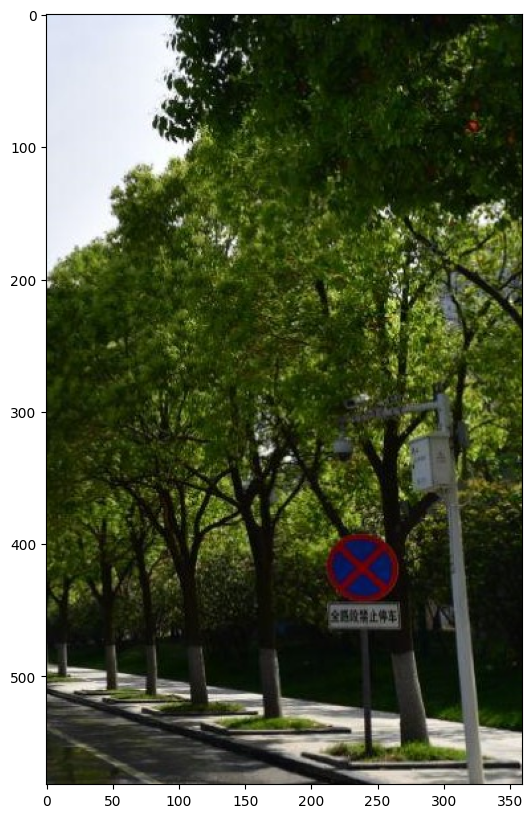

In [7]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

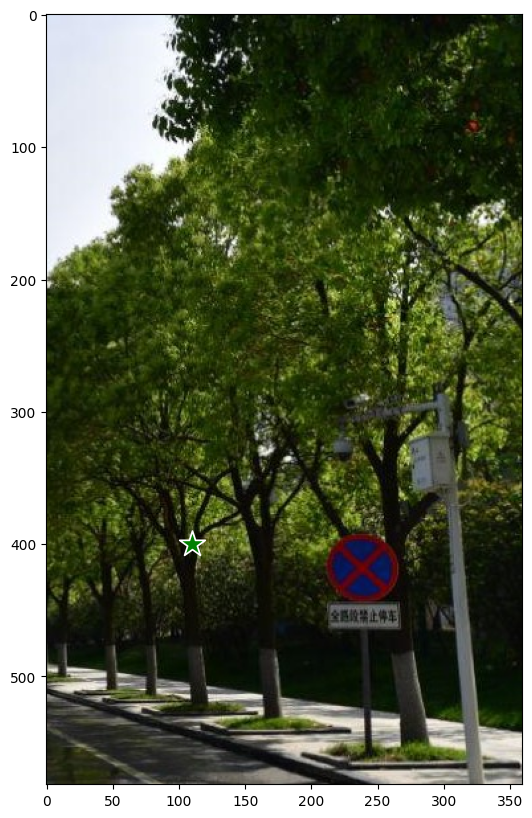

In [14]:
input_point = np.array([[110, 400]])
input_label = np.array([1])
plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()

In [15]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

In [16]:
input_point = np.array([[110, 400], [110, 200], [325, 500]])
input_label = np.array([1, 1, 0])

mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask

In [17]:
masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)

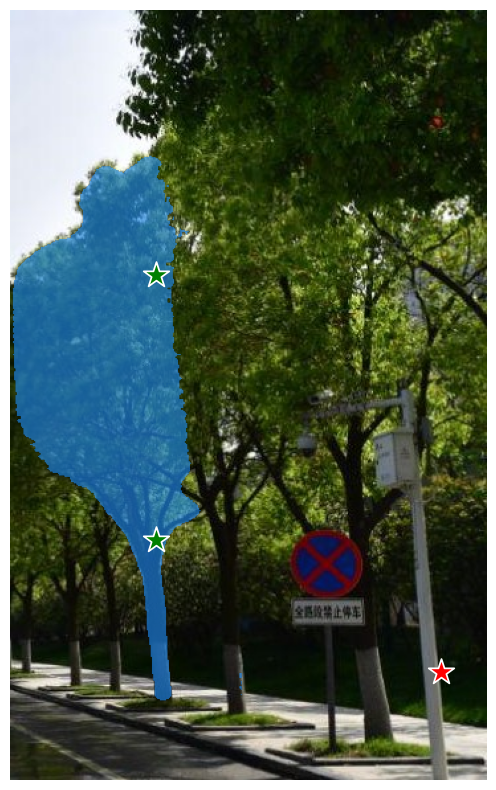

In [18]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()

In [8]:
#Yolo to xyxy
def yolo_to_xyxy(bbox):
  H, W, _ = image.shape
  x_center, y_center, width, height = bbox
  x1 = (x_center - width / 2) * W
  y1 = (y_center - height / 2) * H
  x2 = (x_center + width / 2) * W
  y2 = (y_center + height / 2) * H
  return [x1, y1, x2, y2]

def get_boxes_from_txt(txt_path, device=predictor.device):
    boxes = []

    with open(txt_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 5:
                continue  # skip if not correctly formatted
            _, x_c, y_c, w, h = map(float, parts)
            box = yolo_to_xyxy([x_c, y_c, w, h])
            boxes.append(box)

    input_boxes = torch.tensor(boxes, dtype=torch.float32, device=device)
    return input_boxes

In [9]:
input_boxes = get_boxes_from_txt("/content/images/1.txt", device=predictor.device)
input_boxes

tensor([[192.,   6., 331., 578.],
        [116.,   8., 187., 572.],
        [ 89., 128., 141., 548.],
        [ 64., 165.,  94., 536.],
        [ 29., 182.,  64., 532.],
        [  0., 192.,  22., 515.]], device='cuda:0')